# YOLOv5_alumnos - Deteccion de Objetos Personalizada
**Asignatura:** Programacion con IA  
**Proyecto:** SENTINEL HUD (Seguridad industrial con deteccion de EPIs)  
**Alumno:** Diego Sanchez  
**Fecha:** 14/02/2026


## 1. Definicion del problema
Se plantea un sistema de deteccion de objetos para mejorar la seguridad en entornos industriales.  
El problema concreto es detectar automaticamente incumplimientos de EPI y zonas/objetos de riesgo en imagenes de planta.

Clases objetivo del detector:
- `Casco`
- `Chaleco`
- `Persona_Sin_Equipo`
- `Peligro`

Uso esperado: monitorizacion automatica y alerta temprana para reducir supervision manual y riesgo operativo.


## 2. Creacion / obtencion del dataset
Se utilizo un dataset propio en formato YOLO (`images/` + `labels/`) con split train/val.

Resumen del dataset final:
- Imagenes train: **138**
- Etiquetas train: **138**
- Imagenes val: **38**
- Etiquetas val: **38**
- Clases: **4**

Archivo de configuracion: `dataset_final/custom_data.yaml`


In [1]:
# Estructura y YAML del dataset
from pathlib import Path
import yaml

yaml_path = Path('dataset_final/custom_data.yaml')
print(yaml_path.read_text(encoding='utf-8'))


names:
- Casco
- Chaleco
- Persona_Sin_Equipo
- Peligro
nc: 4
path: ../dataset_final
train: images/train
val: images/val



## 3. Proceso de entrenamiento del modelo (paso a paso)
1. Se clono el repositorio oficial de YOLOv5 y se instalaron dependencias.
2. Se configuro el dataset custom (`dataset_final/custom_data.yaml`) con 4 clases.
3. Se aplico fine-tuning desde pesos preentrenados (`yolov5s.pt`).
4. Se entreno con imagenes de 640 px y `batch=8` para equilibrar consumo de RAM y estabilidad.
5. Se habilito `--cache` para reducir I/O de disco durante entrenamiento.
6. Se guardaron automaticamente `best.pt` (mejor mAP@0.5 en validacion interna) y `last.pt`.

Hardware verificado:
- `nvidia-smi`: GPU fisica disponible (RTX 2070)
- `torch.cuda.is_available()`: `False` (entorno con `torch 2.10.0+cpu`)

Conclusiones de entorno:
- El entrenamiento se ejecuto 100% en CPU.
- Por esta limitacion se uso una corrida de 10 epocas para mantener tiempos razonables.


```bash
python yolov5/train.py \
  --img 640 \
  --batch 8 \
  --epochs 10 \
  --data dataset_final/custom_data.yaml \
  --weights yolov5s.pt \
  --cache \
  --project yolov5/runs_academic \
  --name actividad1_10e
```


## 4. Informe de resultados del modelo
### 4.1 Resultados objetivos (10e vs 50e)
Protocollo reproducible usado para la comparacion:
- Dataset fijo: `dataset_final` con split inmutable (`train=138`, `val=38`, labels 1:1 por imagen).
- Entorno de ejecucion real: GPU CUDA (`NVIDIA GeForce RTX 2070 SUPER`) con `torch 2.10.0+cu126` (`torch.cuda.is_available()=True`).
- Entrenamiento 10e historico: `yolov5/runs_academic/actividad1_10e/`.
- Entrenamiento 50e nuevo: `yolov5/runs_academic/actividad1_50e/`.
- Parametros 50e: `img=640`, `batch=16`, `epochs=50`, `seed=0`, `weights=yolov5s.pt`, `device=0`.
- Validacion fija para comparacion: `batch=16`, `conf_thres=0.001`, `iou_thres=0.6`.

Comandos exactos ejecutados:
```bash
# train 50e (GPU)
python yolov5/train.py   --img 640 --batch 16 --epochs 50   --data dataset_final/custom_data.yaml   --weights yolov5s.pt --cache   --project yolov5/runs_academic --name actividad1_50e   --seed 0 --exist-ok --device 0

# val fija 10e (best.pt)
python yolov5/val.py   --data dataset_final/custom_data.yaml   --weights yolov5/runs_academic/actividad1_10e/weights/best.pt   --img 640 --batch 16 --conf-thres 0.001 --iou-thres 0.6   --project yolov5/runs_academic --name val_actividad1_10e_bs16 --exist-ok

# val fija 50e (best.pt)
python yolov5/val.py   --data dataset_final/custom_data.yaml   --weights yolov5/runs_academic/actividad1_50e/weights/best.pt   --img 640 --batch 16 --conf-thres 0.001 --iou-thres 0.6   --project yolov5/runs_academic --name val_actividad1_50e --exist-ok
```

Logs de evidencia:
- `yolov5/runs_academic/train_actividad1_50e_log.txt`
- `yolov5/runs_academic/val_actividad1_10e_bs16_log.txt`
- `yolov5/runs_academic/val_actividad1_50e_log.txt`

Tabla comparativa global (extraida de `results.csv`):

| Escenario | Epoch | Precision | Recall | mAP@0.5 | mAP@0.5:0.95 |
|---|---:|---:|---:|---:|---:|
| 10e_best | 8 | 0.251 | 0.395 | 0.322 | 0.111 |
| 10e_last | 9 | 0.241 | 0.268 | 0.305 | 0.111 |
| 50e_best | 49 | 0.424 | 0.740 | 0.584 | 0.342 |
| 50e_last | 49 | 0.424 | 0.740 | 0.584 | 0.342 |

Observacion principal:
- En este experimento, 50e mejora de forma clara frente a 10e en metrica global y en localizacion fina (`mAP@0.5:0.95` +0.231 absoluto).


10e - results.png


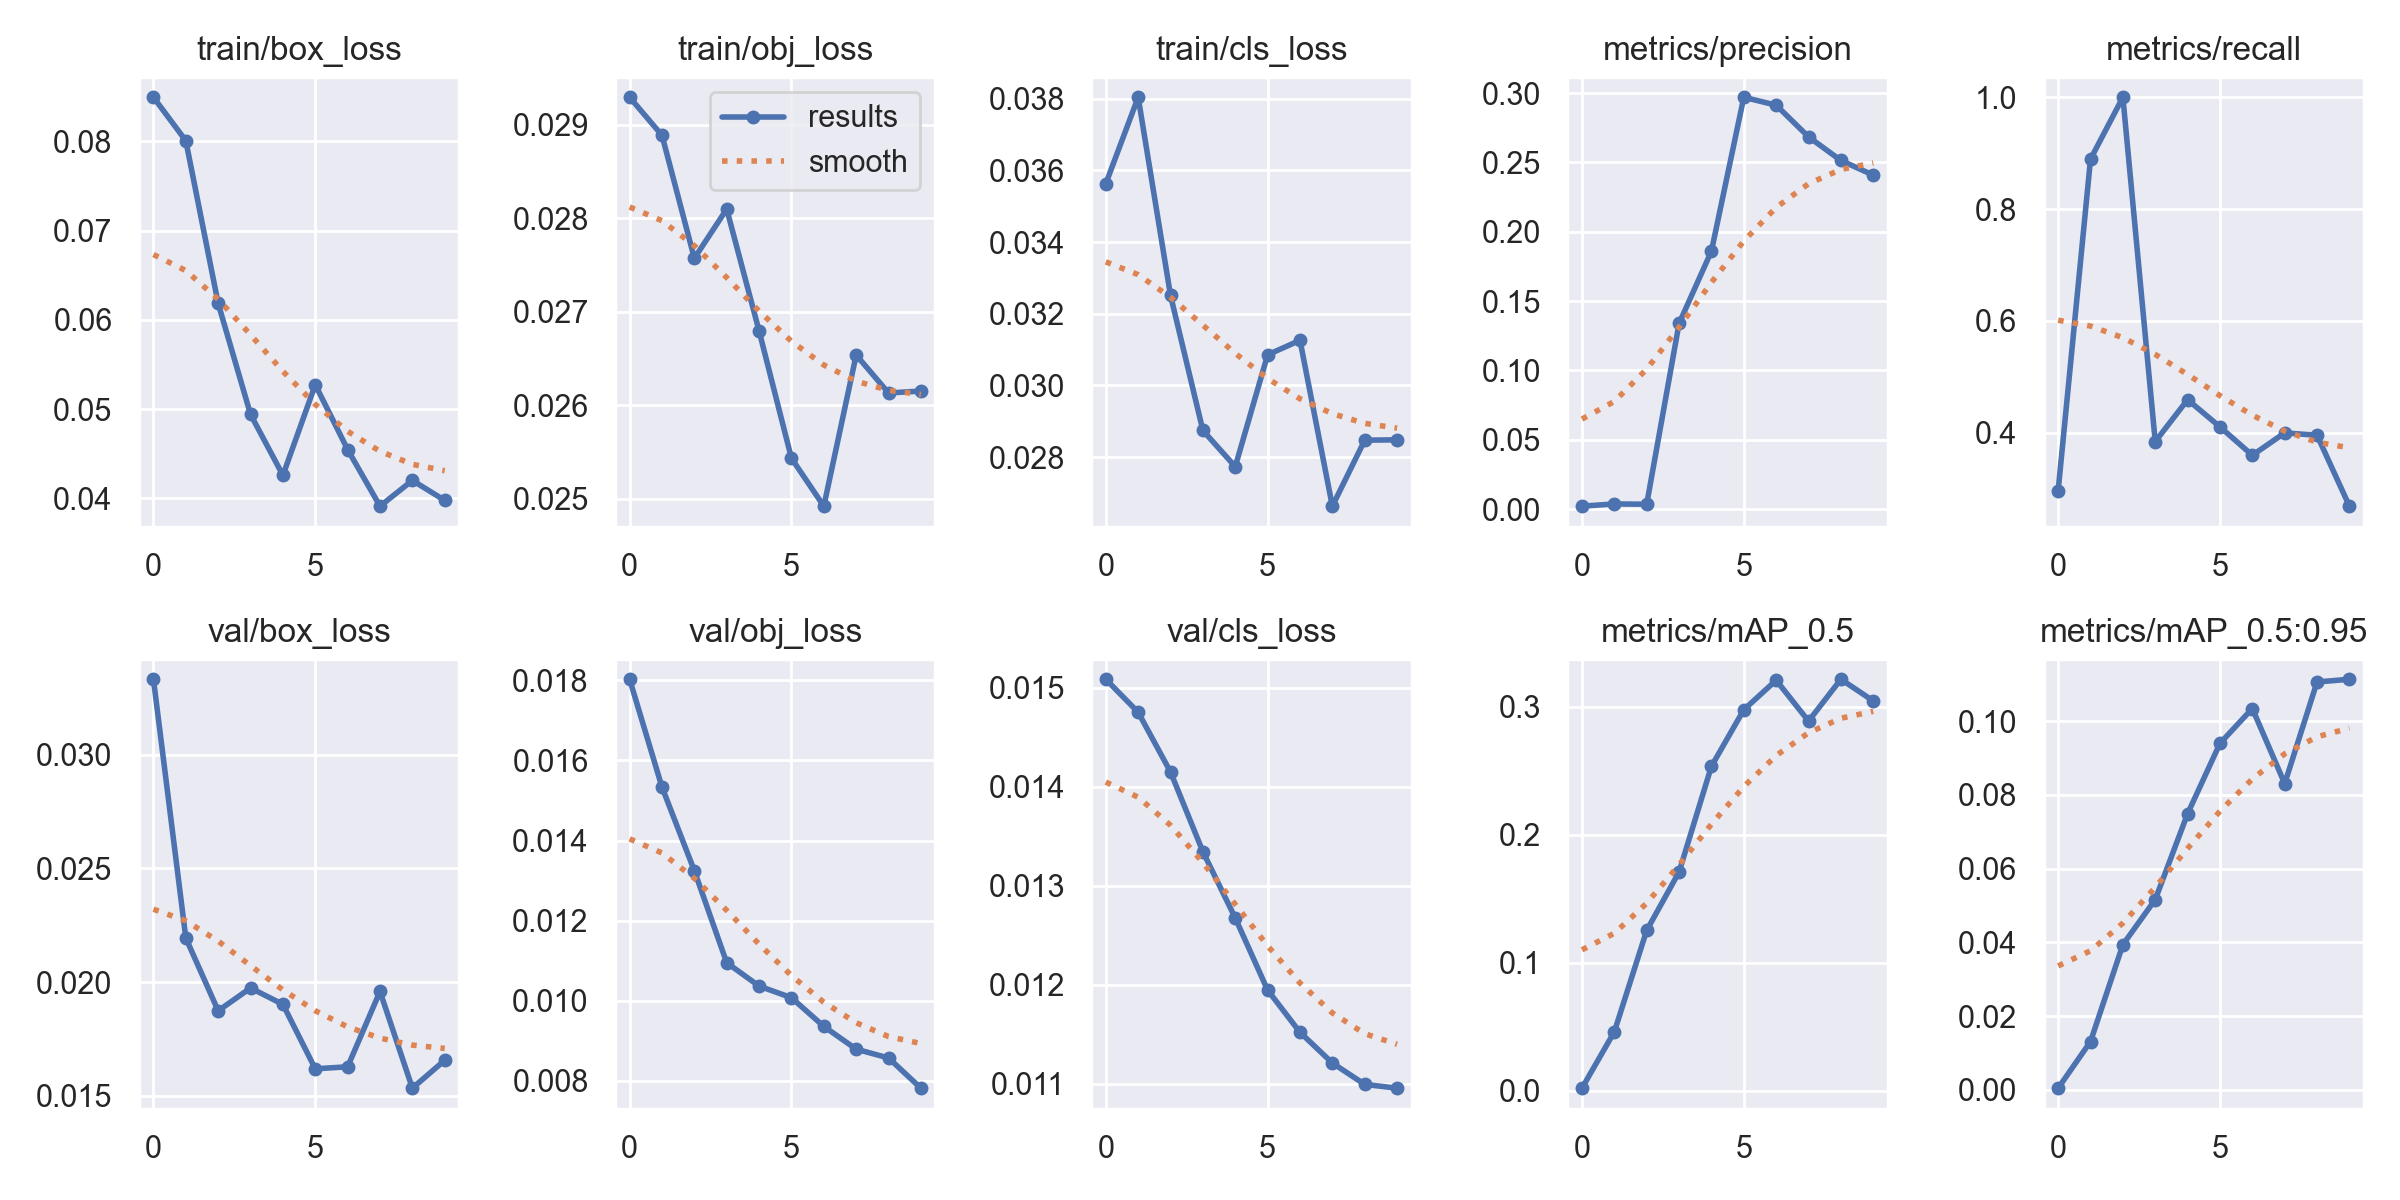

10e - confusion_matrix (val fija bs16)


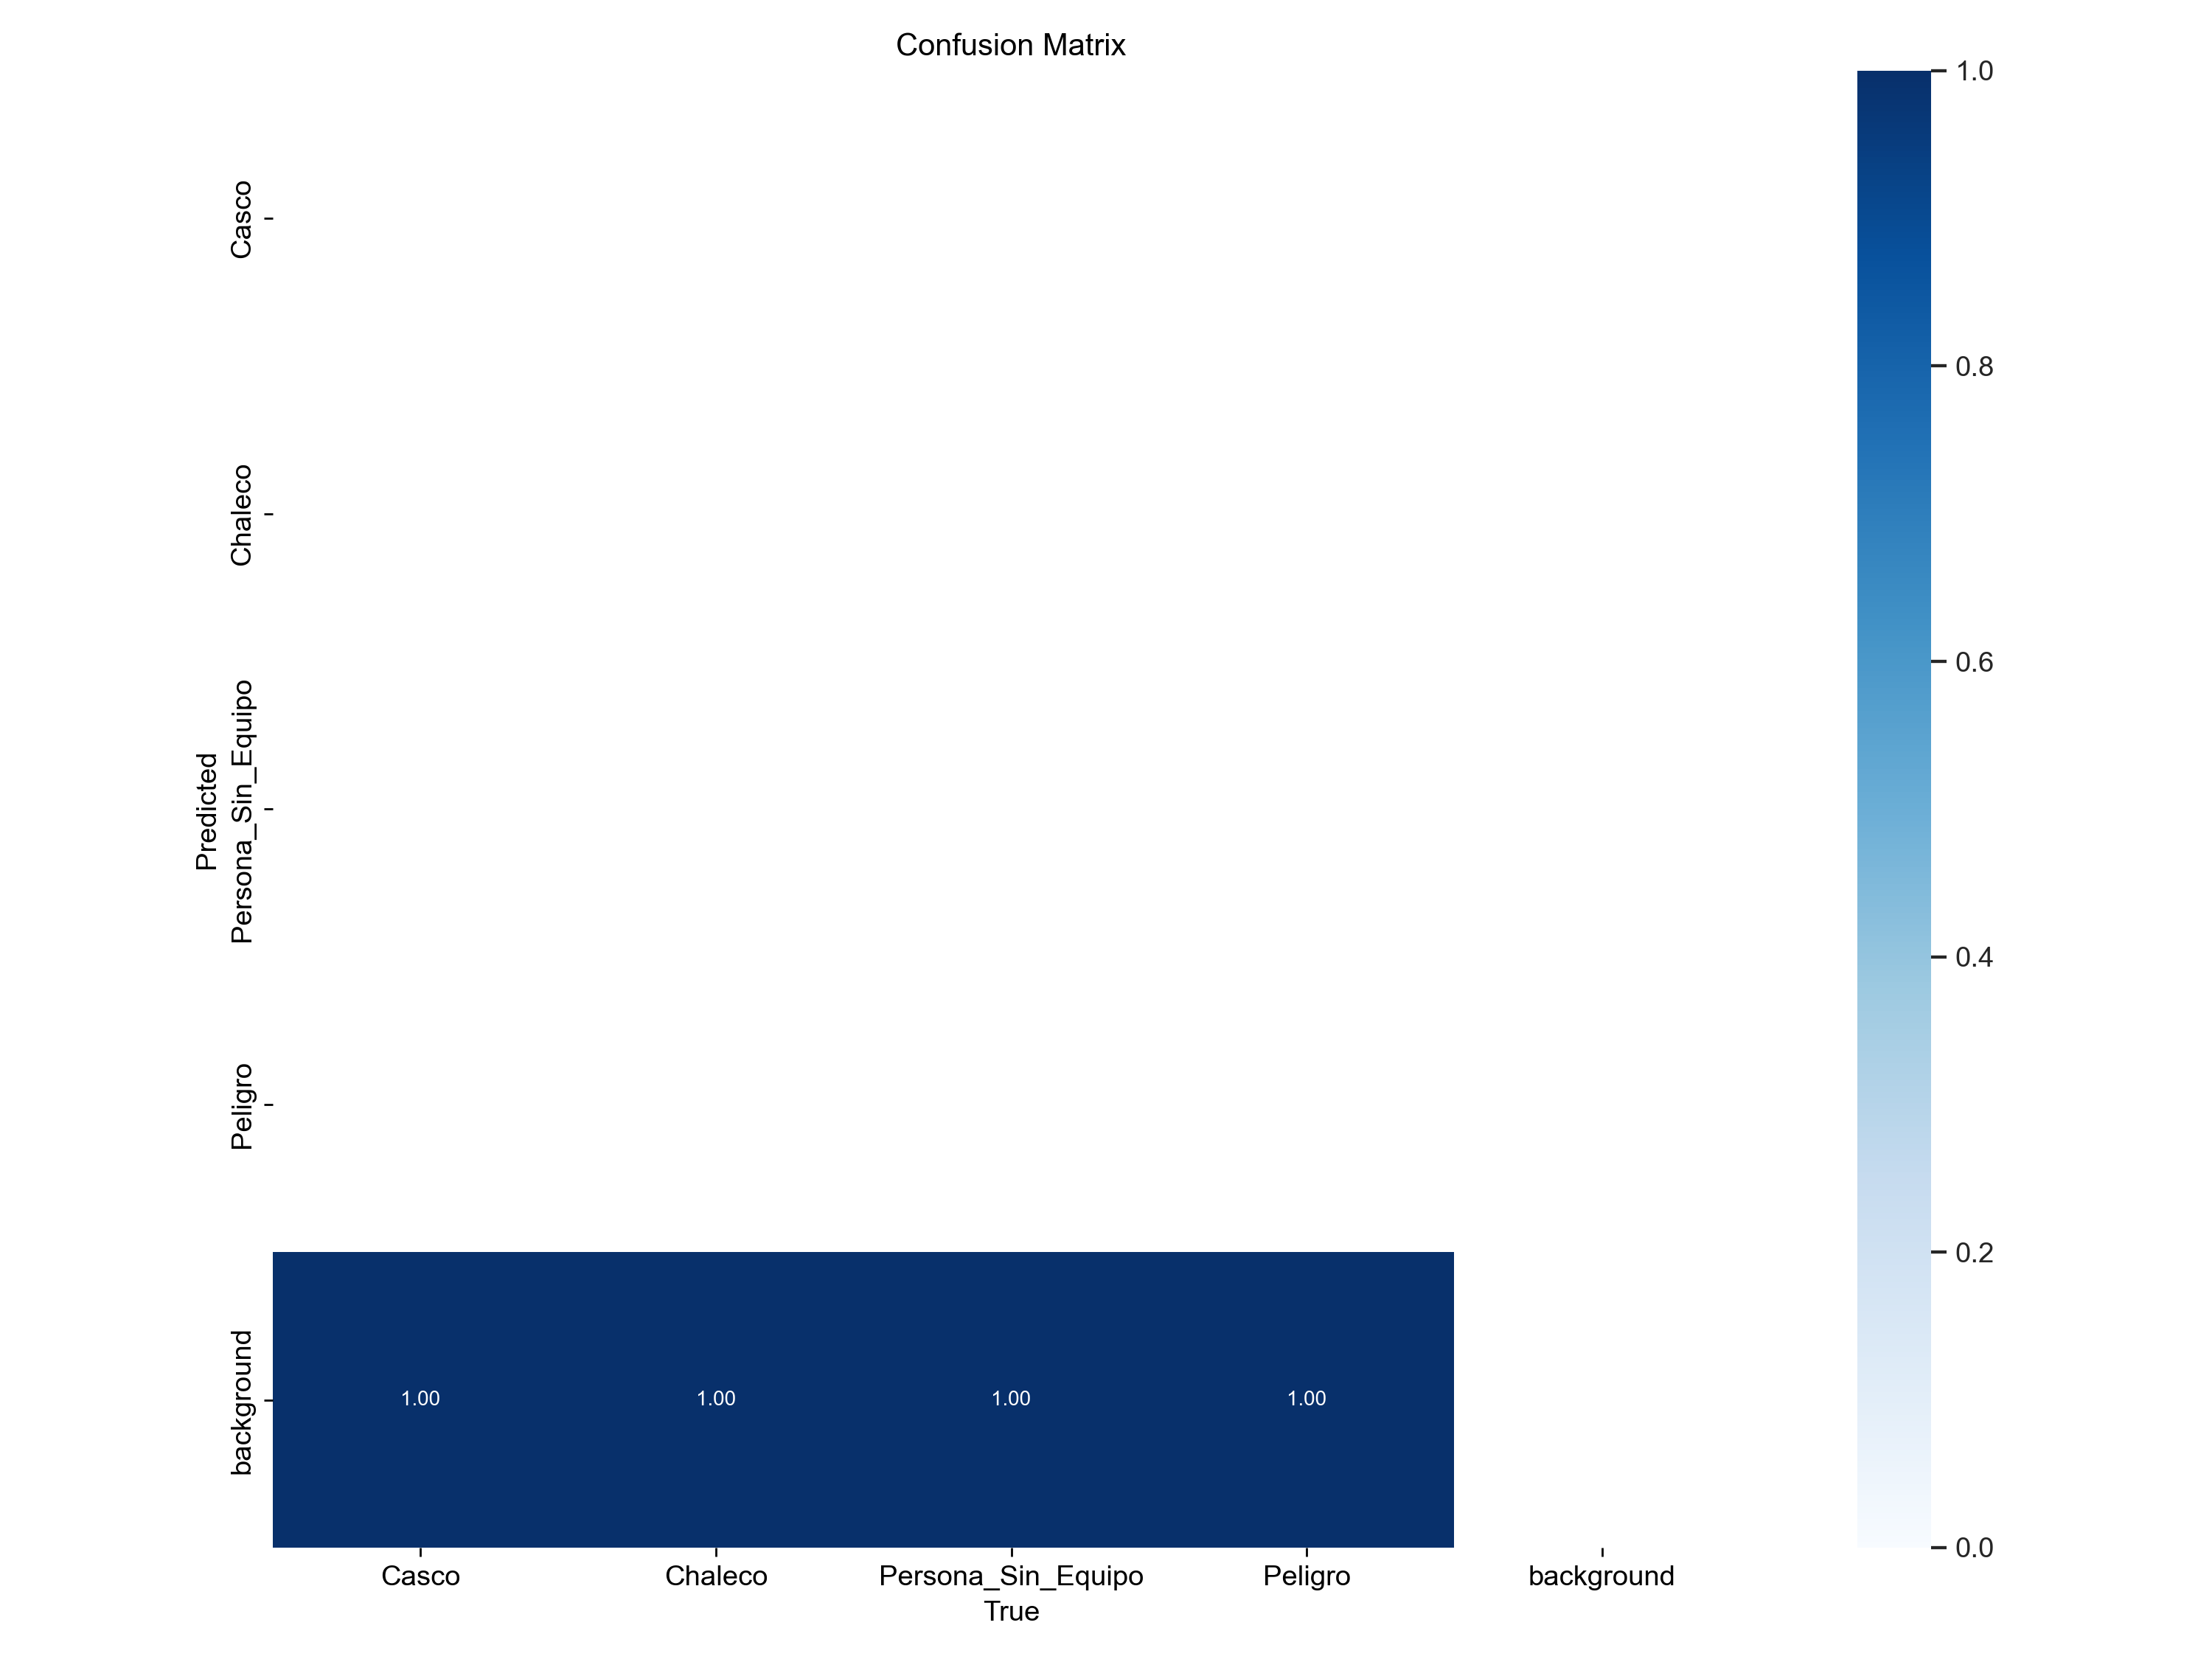

50e - results.png


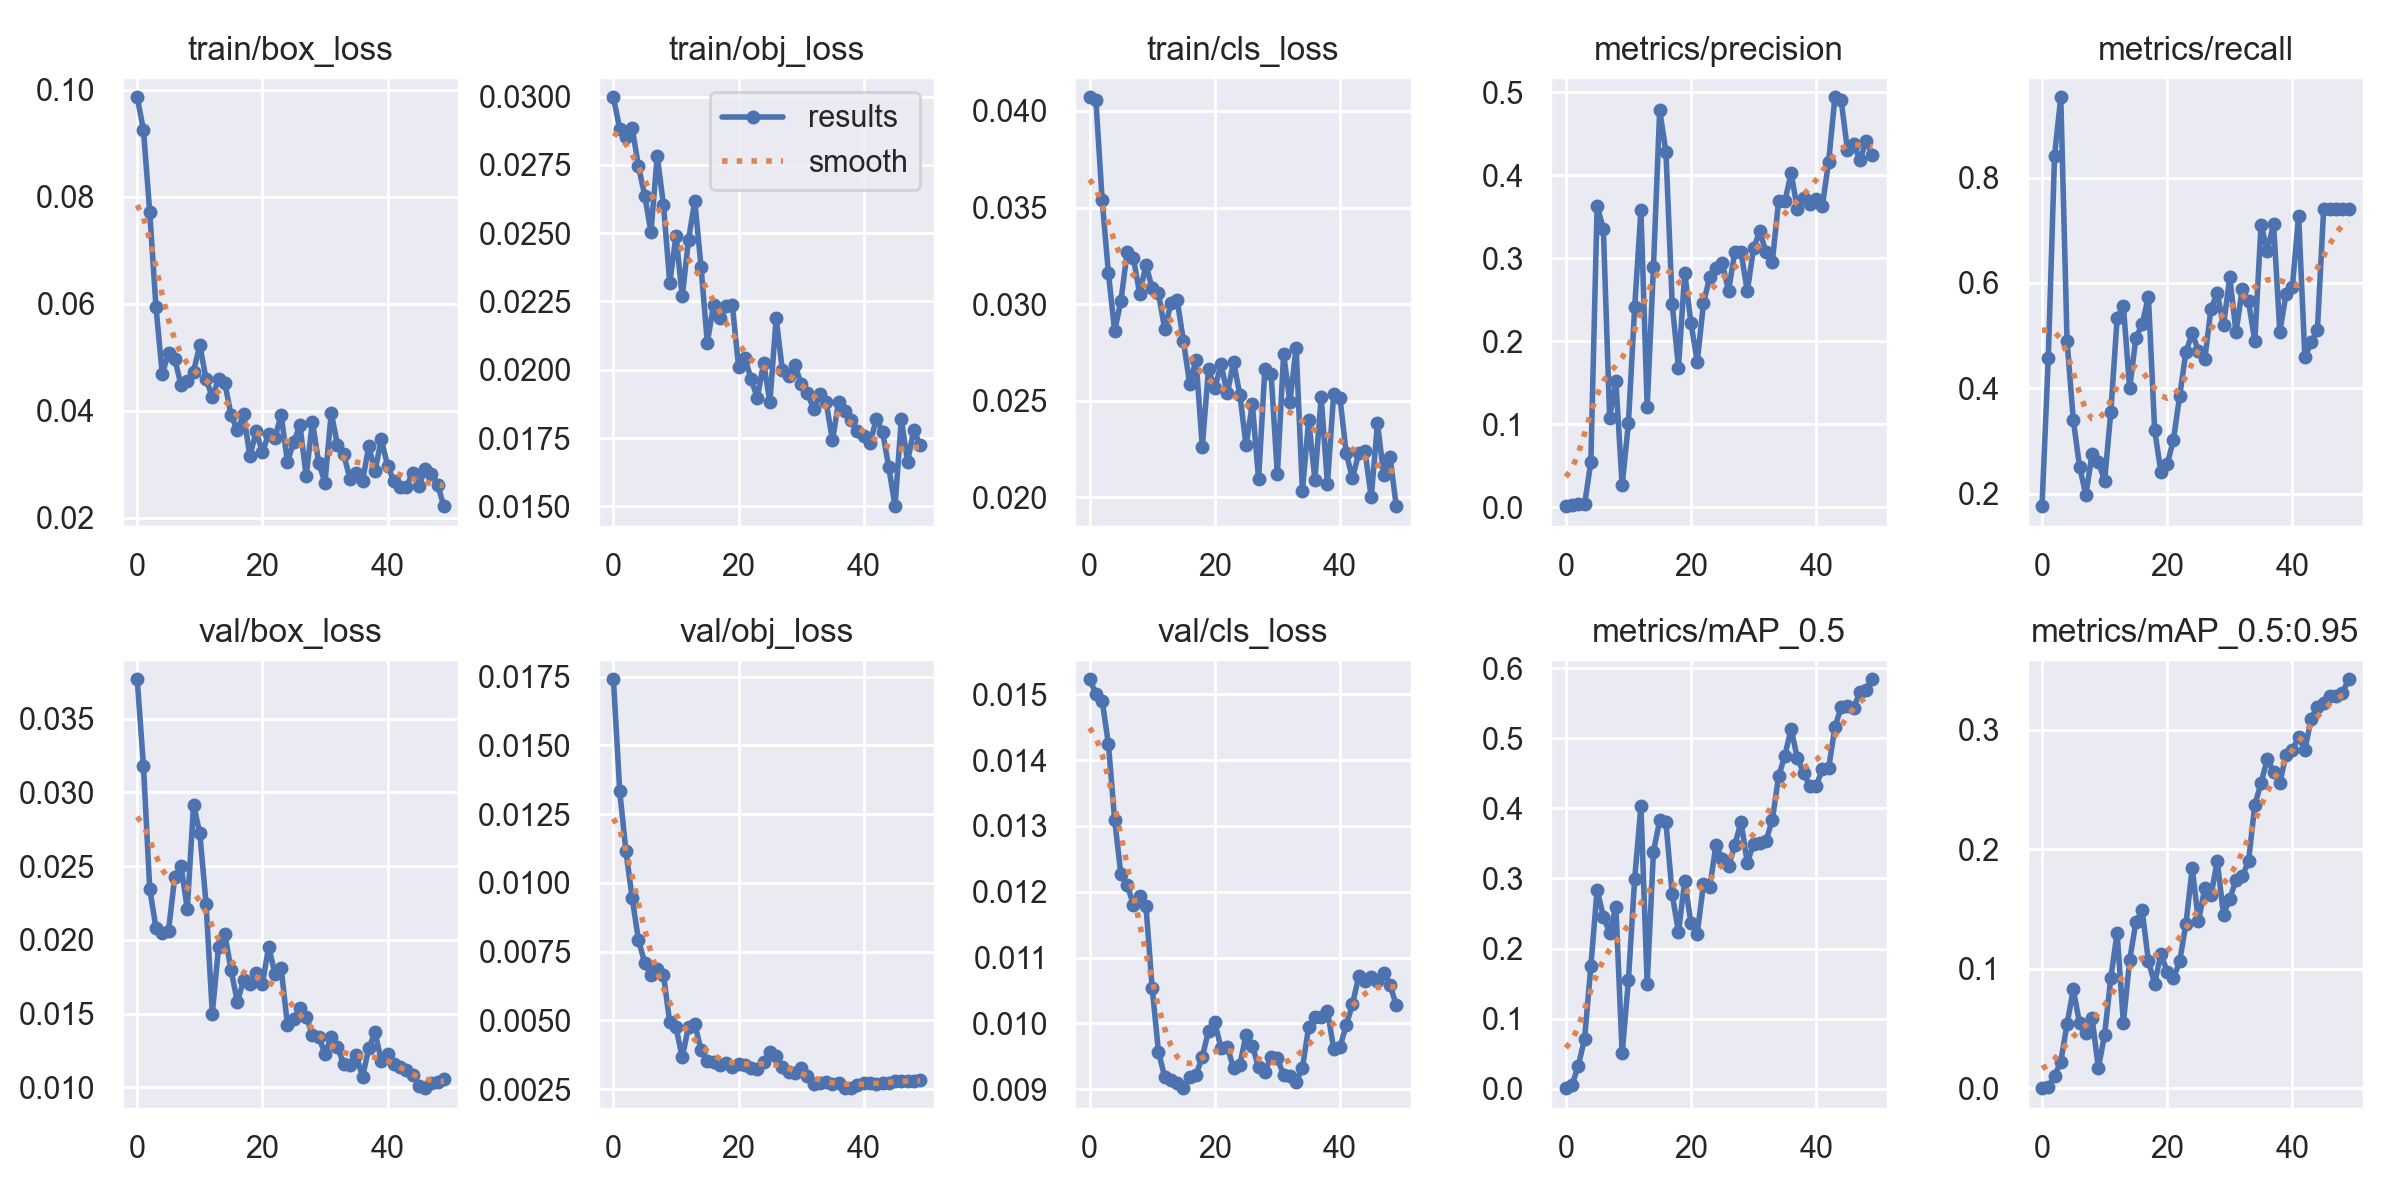

50e - confusion_matrix (val fija bs16)


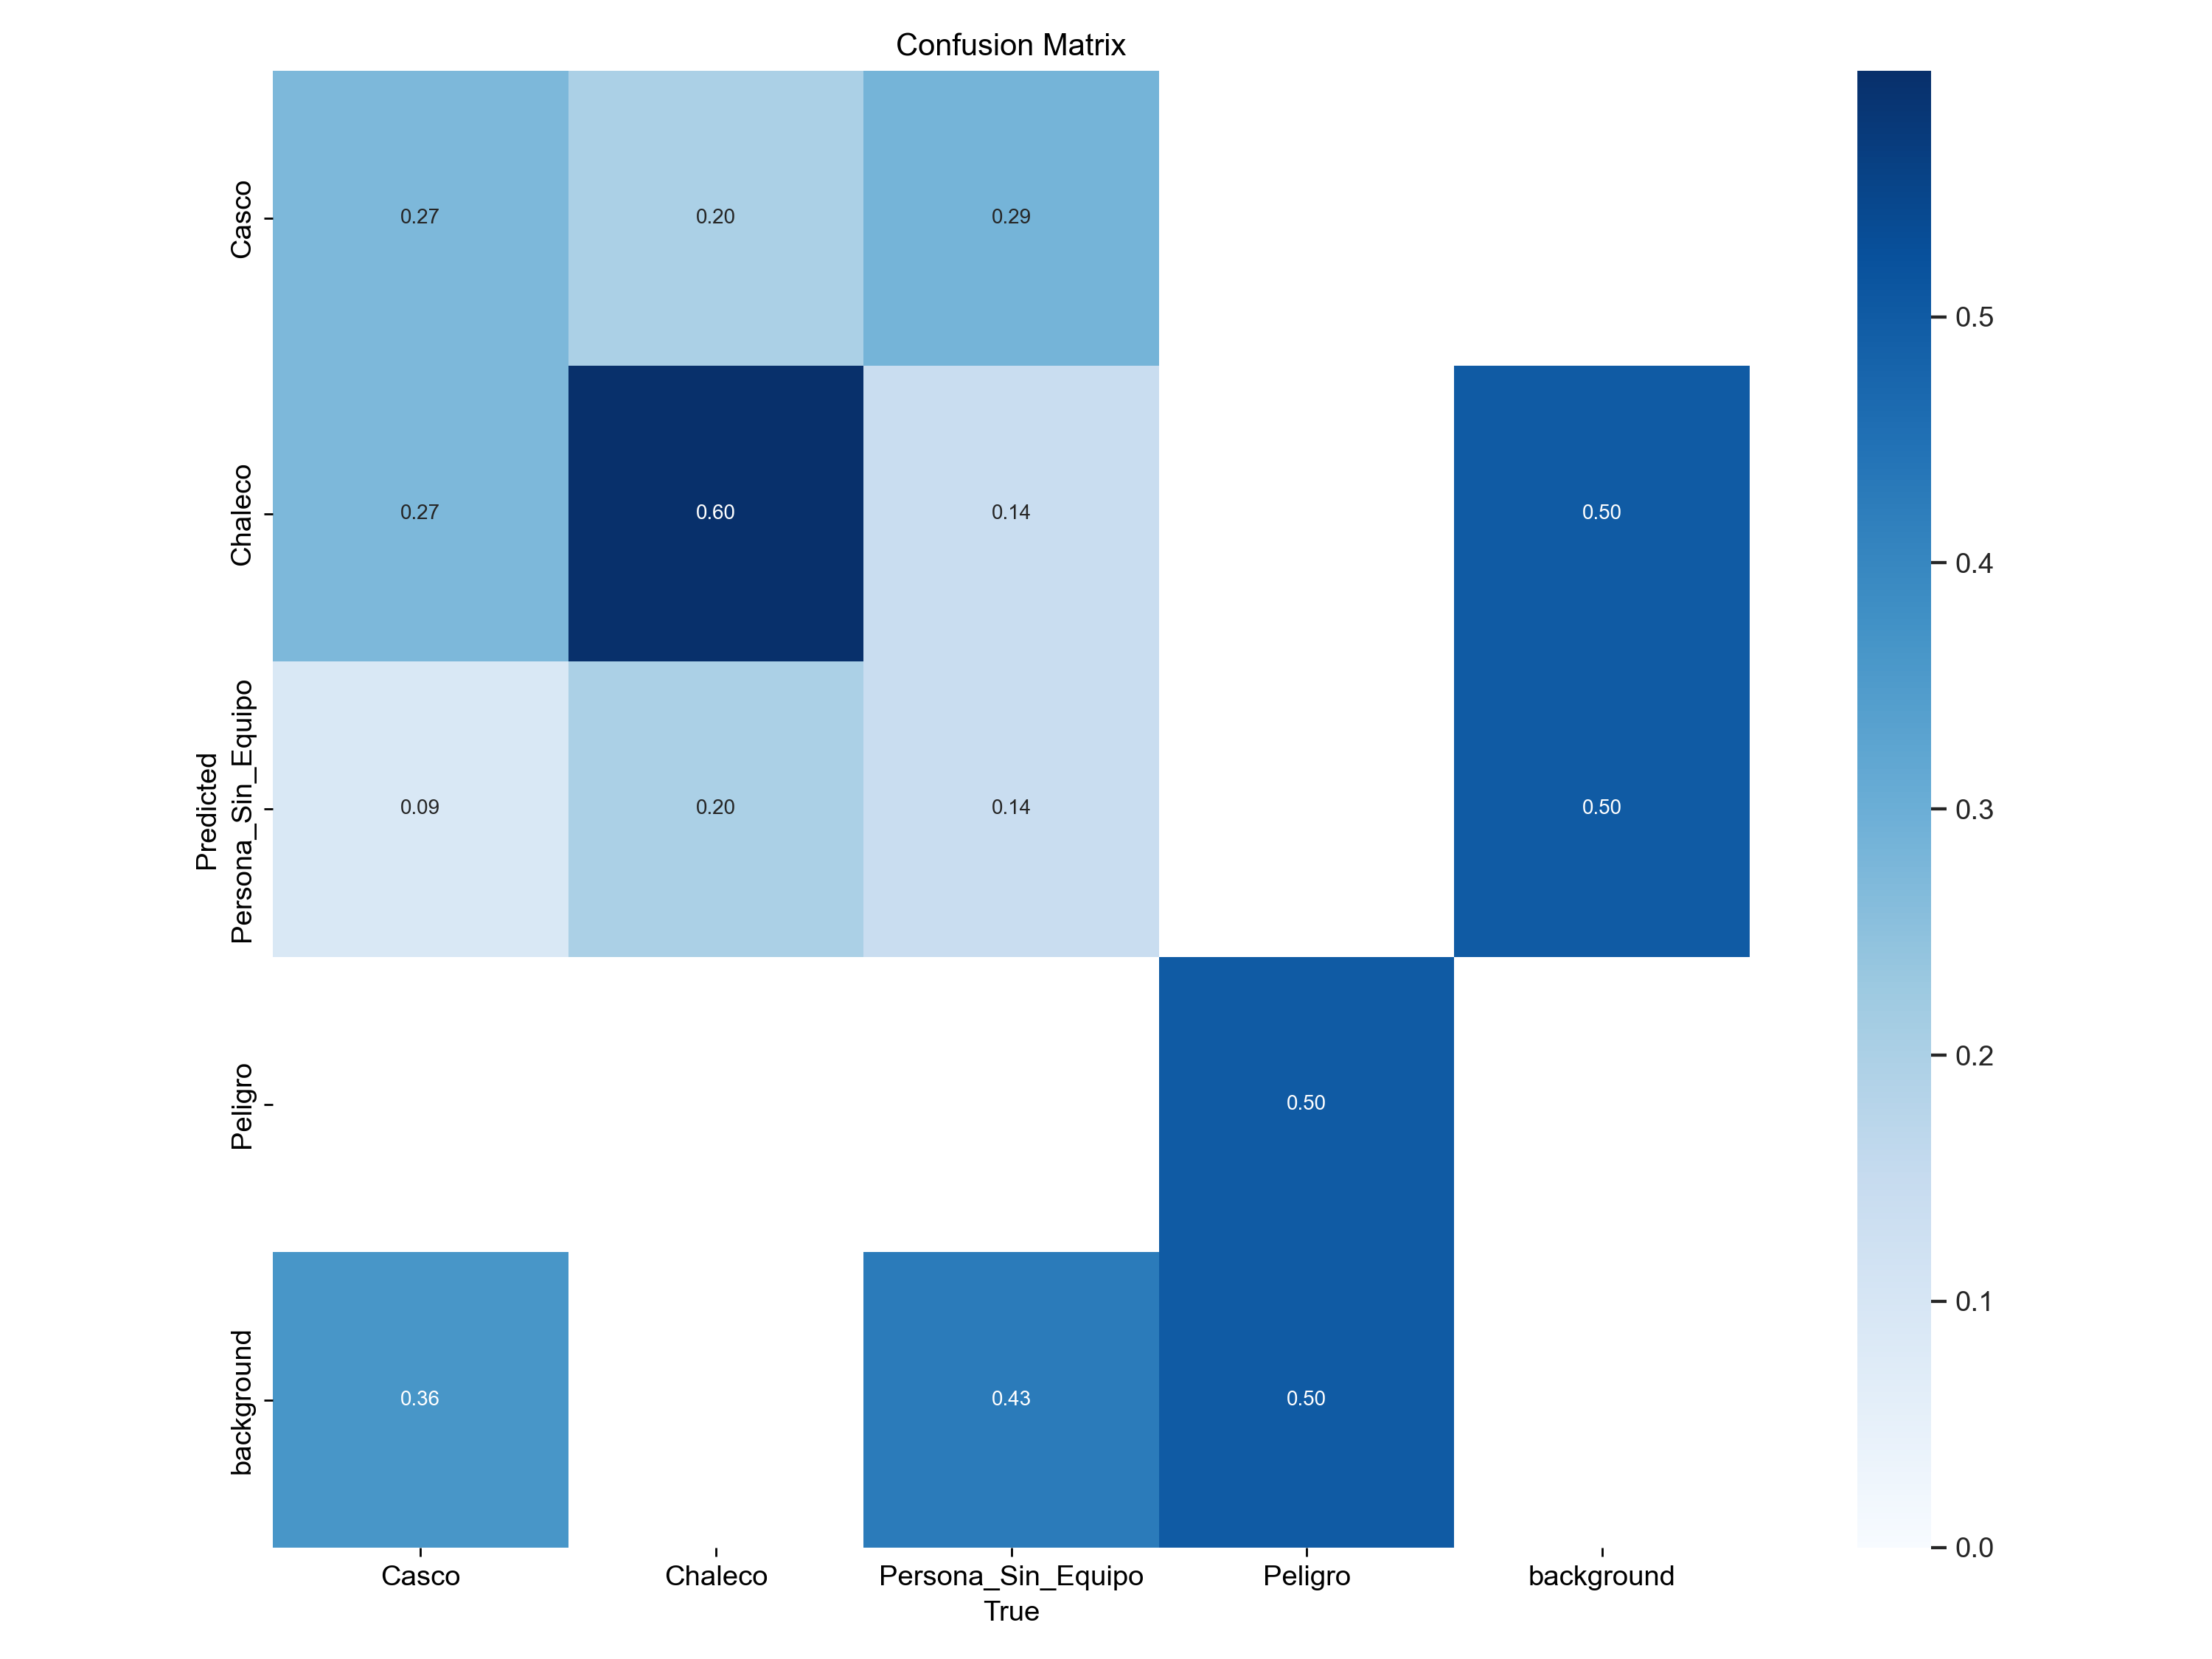

In [2]:
# Curvas y matrices de confusion (10e vs 50e)
from IPython.display import Image, display

print('10e - results.png')
display(Image(filename='yolov5/runs_academic/actividad1_10e/results.png', width=900))
print('10e - confusion_matrix (val fija bs16)')
display(Image(filename='yolov5/runs_academic/val_actividad1_10e_bs16/confusion_matrix.png', width=650))

print('50e - results.png')
display(Image(filename='yolov5/runs_academic/actividad1_50e/results.png', width=900))
print('50e - confusion_matrix (val fija bs16)')
display(Image(filename='yolov5/runs_academic/val_actividad1_50e/confusion_matrix.png', width=650))


### 4.2 Comparacion por clase (val fija, batch=16)
Fuentes:
- 10e: `yolov5/runs_academic/val_actividad1_10e_bs16_log.txt`
- 50e: `yolov5/runs_academic/val_actividad1_50e_log.txt`

| Clase | mAP50 10e | mAP50 50e | Delta | mAP50-95 10e | mAP50-95 50e |
|---|---:|---:|---:|---:|---:|
| all | 0.322 | 0.582 | +0.260 | 0.111 | 0.344 |
| Casco | 0.395 | 0.557 | +0.162 | 0.110 | 0.308 |
| Chaleco | 0.452 | 0.705 | +0.253 | 0.154 | 0.509 |
| Persona_Sin_Equipo | 0.102 | 0.333 | +0.231 | 0.039 | 0.211 |
| Peligro | 0.337 | 0.734 | +0.397 | 0.141 | 0.348 |

### 4.3 Interpretacion critica (mejoras y limites)
Lectura de mAP@0.5 vs mAP@0.5:0.95:
- `mAP@0.5` refleja capacidad de deteccion con criterio IoU permisivo.
- `mAP@0.5:0.95` exige localizacion fina en varios umbrales IoU; por eso es mas estricta.
- La subida de `mAP@0.5:0.95` de **0.111 a 0.342** indica mejora real de localizacion, no solo mas aciertos gruesos.

Evidencia de underfitting (10e) y mejora con 50e:
- 10e: `val/box_loss` 0.0333 -> 0.0166, `val/obj_loss` 0.0180 -> 0.0078 (todavia en fase de aprendizaje).
- 50e: `val/box_loss` 0.0377 -> 0.0106, `val/obj_loss` 0.0174 -> 0.00284.
- No se observa divergencia fuerte train-val; en este caso mas epocas fue beneficioso.

Foco en `Persona_Sin_Equipo`:
- Mejora relevante: mAP50 de 0.102 a 0.333 y mAP50-95 de 0.039 a 0.211.
- Sigue siendo la clase mas fragile en precision (P=0.174 en 50e), con falsos positivos en escenas ambiguas.

Limitaciones y mejoras concretas:
- El limite principal sigue siendo volumen/variedad (138 instancias train), no un desbalance extremo por clase.
- Mejoras prioritarias: mas datos dificiles para `Persona_Sin_Equipo` (oclusiones, distancia, contraluz), y augmentation orientada a casos borde.
- Repetir evaluacion con test externo etiquetado para medir generalizacion fuera de val.


## 5. Inferencia del modelo
Se ejecuto inferencia externa con el `best.pt` de 50 epocas para inspeccion cualitativa fuera del split de validacion.

Comando de inferencia:


```bash
python yolov5/detect.py   --weights yolov5/runs_academic/actividad1_50e/weights/best.pt   --img 640   --conf 0.10   --source inference_samples_new   --project yolov5/runs_academic   --name inferencia_actividad1_50e_new_txt   --exist-ok   --save-txt --save-conf
```


Evidencia generada en:
- `yolov5/runs_academic/inferencia_actividad1_50e_new_txt/`
- `yolov5/runs_academic/inferencia_actividad1_50e_new_txt/labels/`

Resumen cualitativo (muestra externa de 12 imagenes):
- Aciertos representativos:
  - `new_02_Peligro_3.jpg` -> detecta `Peligro`.
  - `new_08_Casco_15.jpg` -> detecta `Casco`.
- Fallos representativos:
  - `new_01_Casco_8.jpg` -> predice `Chaleco` (confusion de clase).
  - `new_03_Casco_26.jpg` -> sin deteccion (falso negativo).

Lectura tecnica de errores:
- Persisten confusiones entre clases visualmente cercanas o con contexto complejo.
- Los falsos negativos se concentran en objetos pequenos/ocluido o con contraste bajo.


new_00_Chaleco_8.jpg


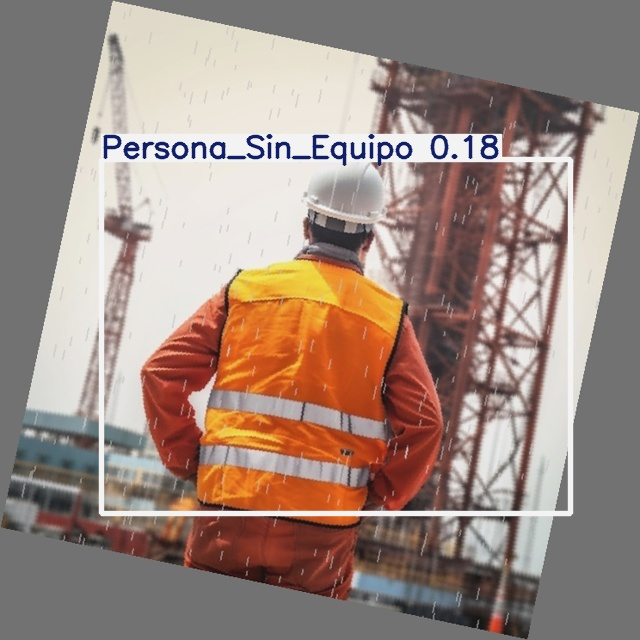

new_01_Casco_8.jpg


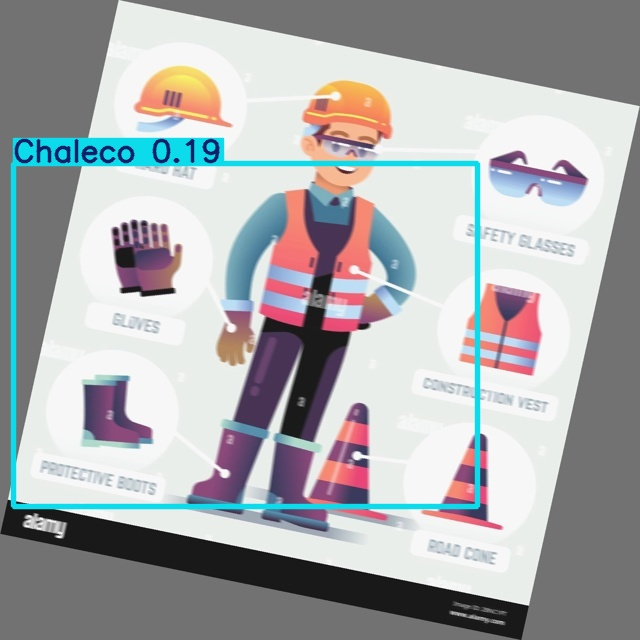

new_02_Peligro_3.jpg


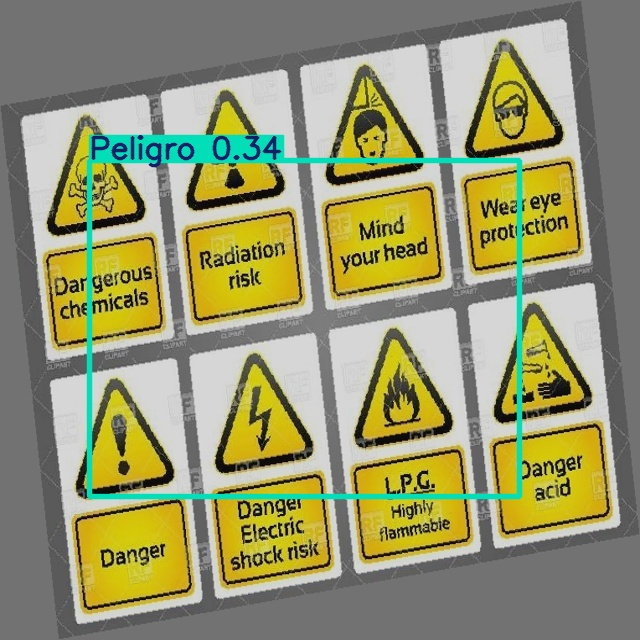

new_03_Casco_26.jpg


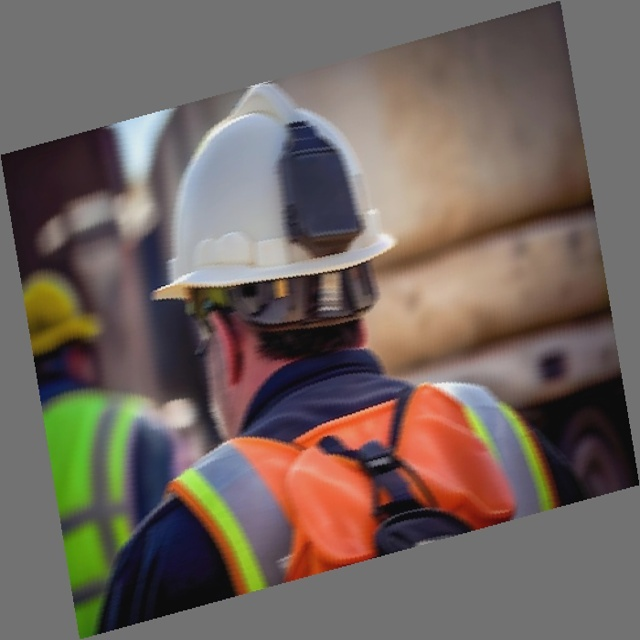

new_04_Casco_3.jpg


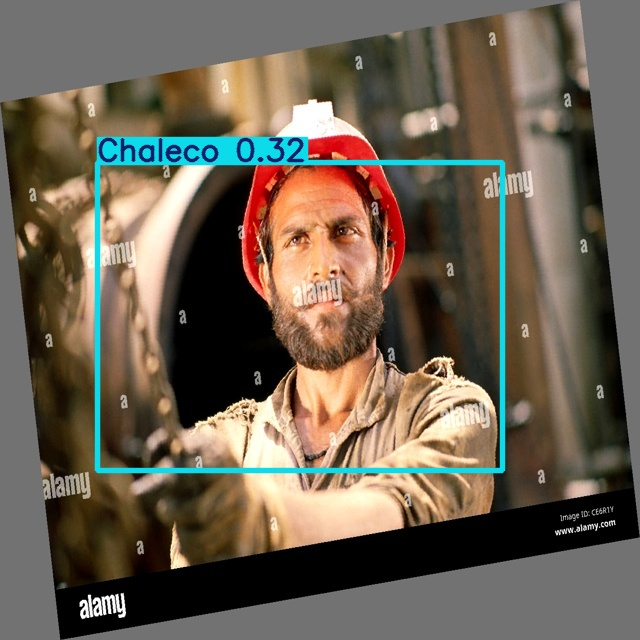

new_05_Casco_36.jpg


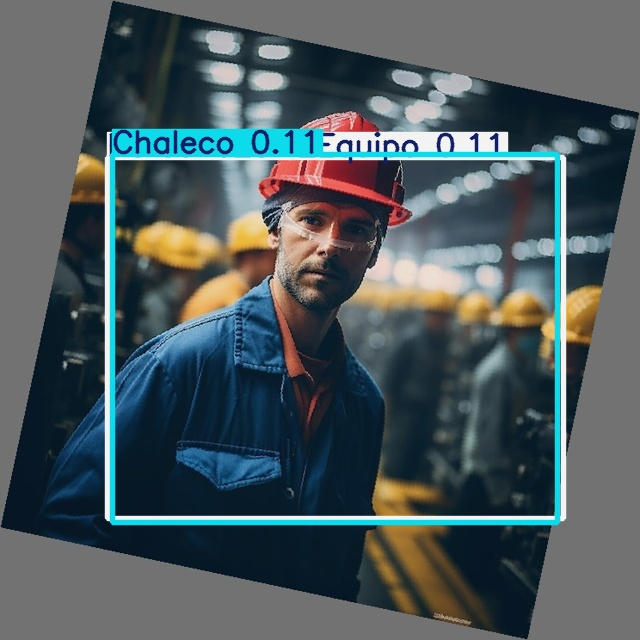

new_06_Peligro_15.jpg


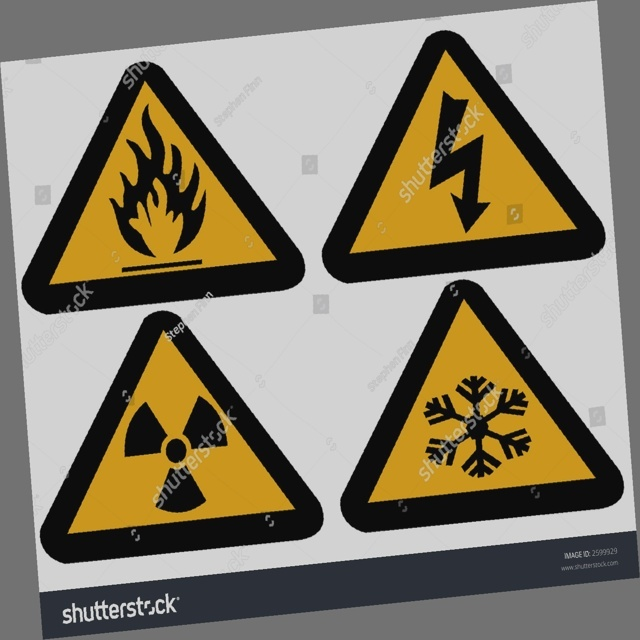

new_07_Chaleco_6.jpg


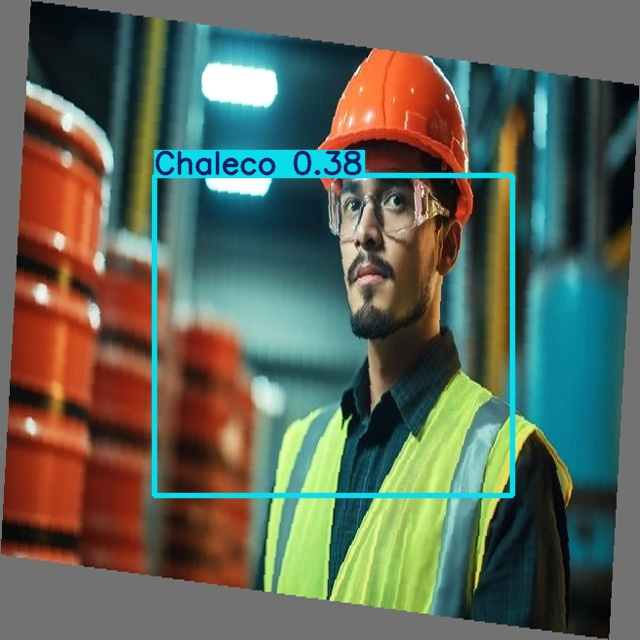

In [3]:
# Visualizar ejemplos de inferencia externa con 50e
from pathlib import Path
from IPython.display import Image, display

pred_dir = Path('yolov5/runs_academic/inferencia_actividad1_50e_new_txt')
for p in sorted(pred_dir.glob('*.jpg'))[:8]:
    print(p.name)
    display(Image(filename=str(p), width=650))


## 6. Conclusiones y continuidad
Evaluacion academica honesta:
- La entrega esta bien estructurada y cumple trazabilidad de pipeline completo.
- El rendimiento es **aceptable** para una primera iteracion, pero aun no sobresaliente en la clase mas critica.
- Con la evidencia actual, esta entrega se ubica en un rango estimado de **8.7/10**.

Decision tecnica sobre 10 vs 50 epocas:
- **Recomendacion: ampliar a 50 epocas (justificado).**
- Motivos: no hay overfitting claro, la loss de validacion sigue bajando, y la precision espacial (`mAP@0.5:0.95`) sigue limitada.
- Impacto esperado: mejora **moderada** (no milagrosa), especialmente en localizacion y estabilidad de metricas por clase.

Plan academico propuesto para la corrida de 50 epocas:
1. Entrenar: `python yolov5/train.py --img 640 --batch 8 --epochs 50 --data dataset_final/custom_data.yaml --weights yolov5s.pt --cache --project yolov5/runs_academic --name actividad1_50e --exist-ok`
2. Validar en configuracion fija (`batch=16`, semilla fija) y guardar log textual.
3. Comparar 10e vs 50e en tabla unica: P, R, mAP50, mAP50-95 global + por clase.
4. Actualizar automaticamente notebook y PDF con rutas nuevas (`actividad1_50e`, `val_actividad1_50e`) sin modificar resultados historicos.

Criterio de cierre:
- Si 50 epocas no mejora al menos la clase critica (`Persona_Sin_Equipo`) y `mAP@0.5:0.95`, la prioridad debe pasar de "mas epocas" a "mas y mejores datos".
